In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Pytorch 라이브러리 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Pytorch.utils.data의 Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader

# 1. 유방암 데이터 로드 및 나누기

In [4]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [5]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

print(df.shape)
df.tail()

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [6]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'class'],
      dtype='object')

In [11]:
# mean 데이터로만 입력값을 구성해보자
df.columns[:10]

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension'],
      dtype='object')

In [9]:
# PyTorch Tensor로 변환 후 double을 float로 변환해주기
data = torch.from_numpy(df.values).float()   

data.shape

torch.Size([569, 31])

### columns -> features, target 나누기

In [89]:
# mean 데이터로만 입력값을 구성
x = data[:, :10]

# class(0 or 1)는 타겟값으로 구성
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([569, 10]) torch.Size([569, 1])


## train set, validation, test set으로 랜덤하게 나누기

In [90]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

In [91]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 341 / Valid 113 / Test 115 samples.


In [92]:
# train, validation 데이터를 random index 기준으로 나누기
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([341, 10]) torch.Size([341, 1])
torch.Size([113, 10]) torch.Size([113, 1])
torch.Size([115, 10]) torch.Size([115, 1])


# 2. 학습 준비 (by Dataset, DataLoader)

In [93]:
# Set Hyper Parameters
n_epochs = 10000
batch_size = 128
print_interval = 500
early_stop = 100

In [94]:
from torch.utils.data import Dataset, DataLoader

In [95]:
# DataSet에서 데이터 읽고, 전처리(데이터 나누기, Scaling)
class CustomDataset(Dataset):  # Dataset 클래스를 상속받는다.
    
    # 데이터 읽어오기
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
        super().__init__()
        
    # 데이터의 크기 알기
    def __len__(self):
        return len(self.data)
    
    # 전처리 및 미니배치를 위한 샘플 반환
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [96]:
# DataLoader에서 iterator가 shuffle, 미니배치 chinking, iteration 세팅
train_loader = DataLoader(
    dataset=CustomDataset(x[0], y[0]),
    batch_size=batch_size,
    shuffle=True,    # 학습 셋만 shuffling이 필수다
)

valid_loader = DataLoader(
    dataset=CustomDataset(x[1], y[1]),
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=CustomDataset(x[2], y[2]),
    batch_size=batch_size,
    shuffle=False,
)

In [97]:
# train, valid, test 데이터 각각의 DataLoader 객체 생성 완료
print("Train %d / Valid %d / Test %d samples." % (
    len(train_loader.dataset),
    len(valid_loader.dataset),
    len(test_loader.dataset),
))

Train 341 / Valid 113 / Test 115 samples.


In [98]:
# 학습 셋(341)을 batch_size(128)로 나누기 : train_loader는 3 chunk(128/128/85 samples)로 나뉘어짐

i = 0
for x_i, y_i in train_loader:
    print(i, len(x_i), x_i)
    i+=1

0 128 tensor([[1.2770e+01, 2.2470e+01, 8.1720e+01,  ..., 2.7040e-02, 1.5850e-01,
         6.0650e-02],
        [1.2450e+01, 1.6410e+01, 8.2850e+01,  ..., 4.8460e-02, 2.0820e-01,
         7.3250e-02],
        [1.2340e+01, 2.6860e+01, 8.1150e+01,  ..., 4.5620e-02, 1.9430e-01,
         6.9370e-02],
        ...,
        [1.1750e+01, 2.0180e+01, 7.6100e+01,  ..., 3.7380e-02, 1.9930e-01,
         6.4530e-02],
        [1.3030e+01, 1.8420e+01, 8.2610e+01,  ..., 2.9230e-02, 1.4670e-01,
         5.8630e-02],
        [1.8010e+01, 2.0560e+01, 1.1840e+02,  ..., 7.7620e-02, 2.1160e-01,
         6.0770e-02]])
1 128 tensor([[1.5660e+01, 2.3200e+01, 1.1020e+02,  ..., 1.3770e-01, 2.4950e-01,
         8.1040e-02],
        [1.1930e+01, 2.1530e+01, 7.6530e+01,  ..., 2.0080e-02, 1.6880e-01,
         6.1940e-02],
        [2.0090e+01, 2.3860e+01, 1.3470e+02,  ..., 1.2800e-01, 2.2490e-01,
         7.4690e-02],
        ...,
        [2.8110e+01, 1.8470e+01, 1.8850e+02,  ..., 1.5950e-01, 1.6480e-01,
         5.52

# 3. Build Model & Optimizer

In [99]:
print(x[0].size(-1))  # 입력 데이터 차원 수 : 10
print(y[0].size(-1))  # 출력 데이터 차원 수 : 1 (sigmoid binary classification)

10
1


In [100]:
# DNN 모델 구성(이진 분류)
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),  # 입력 데이터 10차원 -> 6
    nn.LeakyReLU(),               
    nn.Linear(6, 5),              # 6 -> 5
    nn.LeakyReLU(),
    nn.Linear(5, 4),              # 5 -> 4
    nn.LeakyReLU(),
    nn.Linear(4, 3),              # 4 -> 3
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),  # 3 -> 출력 1차원
    nn.Sigmoid(),   # 이진 분류이므로 sigmoid
)

model

Sequential(
  (0): Linear(in_features=10, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
  (9): Sigmoid()
)

In [101]:
# 옵티마이저는 adam
optimizer = optim.Adam(model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

# 4. 학습(Train)

In [102]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

lowest_epoch = np.inf

In [103]:
import torch.nn.functional as F

# 학습 히스토리 plot 그려보기
train_history, valid_history = [], []

for i in tqdm_notebook(range(n_epochs)):
    
    # 모델의 train 모드 turn on
    model.train() 
    
    # (딥초)shuffling and mini-batch chunking for each epoch -> We can remove following code block. 
    # 이제 이 작업은 DataLoader가 대신 해준다.
    # ------------------------------------------------------
    # indices = torch.randperm(x[0].size(0))
    # x_ = torch.index_select(x[0], dim=0, index=indices)
    # y_ = torch.index_select(y[0], dim=0, index=indices)
    #
    # x_ = x_.split(batch_size, dim=0)
    # y_ = y_.split(batch_size, dim=0)
    # ------------------------------------------------------

    train_loss, valid_loss = 0, 0
    y_hat = []
    
    # DataLoader로 준비된 미니배치 chunk를 하나씩 가져와서 학습 iteration을 돌린다.
    # train_loader는 3 chunk(128/128/85 samples)로 나뉘어져 있다. |xi| = (bs=128, 10),   [yi] = (bs=128, 1)
    for x_i, y_i in train_loader:  # 미니배치 chunk 3개를 차례로 돌면서 모델 학습
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)   # 이진 분류 오차 함수

        optimizer.zero_grad()
        loss.backward()       # 오차역전파
        optimizer.step()      # optimizer
        train_loss += float(loss)  # This is very important to prevent memory leak.
    
    # 학습 loss 계산
    train_loss = train_loss / len(train_loader)
    # -> 한 epoch의 학습 끝

    # 모델의 validation 모드 turn on
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        
        for x_i, y_i in valid_loader:
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(valid_loader)
    
    # 매 epoch마다 학습, 검증이 끝나면 train, valid loss들을 history에 저장해둔다.
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    # print_interval(500) epoch마다 학습 진행상황 출력
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    # 매 epoch이 끝날 때 마다 valid loss가 갱신되면 best model로 저장한다.
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:  
        # early_stop 조건동안 valid loss 갱신이 없으면 early_stop 
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model) 

/Users/aiden/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 500: train loss=4.0054e-01  valid_loss=4.2739e-01  lowest_loss=4.2824e-01
Epoch 1000: train loss=2.4316e-01  valid_loss=3.1292e-01  lowest_loss=3.0002e-01
Epoch 1500: train loss=2.3186e-01  valid_loss=2.7513e-01  lowest_loss=2.7092e-01
Epoch 2000: train loss=2.2702e-01  valid_loss=2.5723e-01  lowest_loss=2.4028e-01
Epoch 2500: train loss=1.9388e-01  valid_loss=2.1675e-01  lowest_loss=2.0258e-01
Epoch 3000: train loss=1.8463e-01  valid_loss=1.7310e-01  lowest_loss=1.7031e-01
Epoch 3500: train loss=1.6499e-01  valid_loss=1.5910e-01  lowest_loss=1.5437e-01
Epoch 4000: train loss=1.8802e-01  valid_loss=1.5735e-01  lowest_loss=1.4653e-01
Epoch 4500: train loss=1.8998e-01  valid_loss=1.6274e-01  lowest_loss=1.4287e-01
Epoch 5000: train loss=1.6025e-01  valid_loss=1.9853e-01  lowest_loss=1.4119e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 4908: 1.4119e-01


<All keys matched successfully>

# 5. 학습 결과 확인(plot)

## Loss History

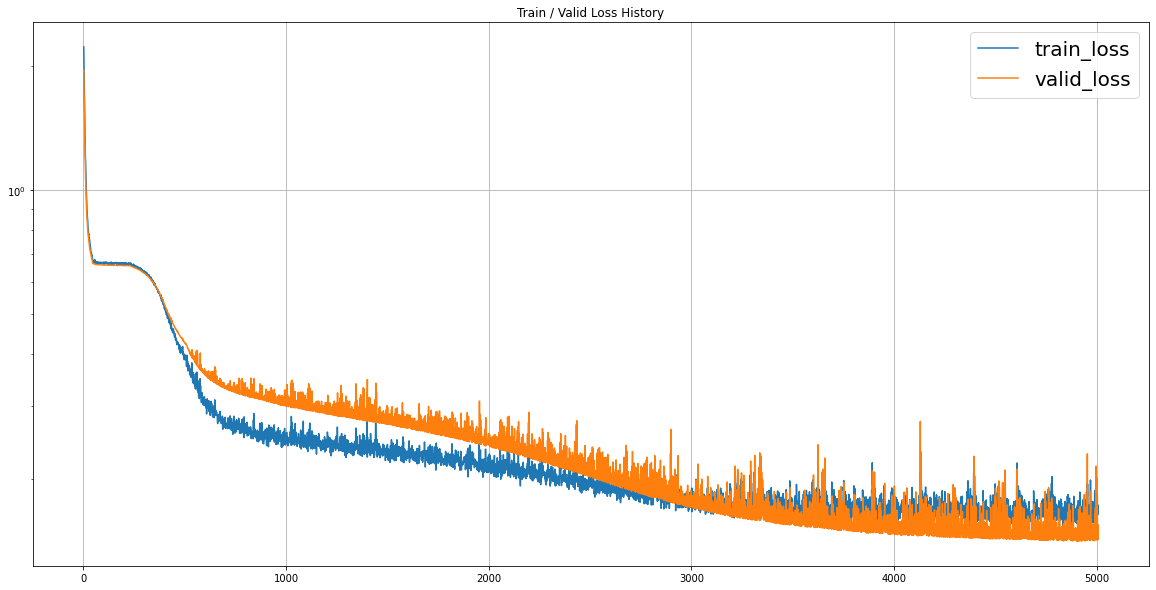

In [109]:
plot_from = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='train_loss')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='valid_loss')
plt.legend(fontsize=20)

plt.yscale('log')
plt.show()

# 6. 테스트(test)

## test loss 확인

In [112]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    for x_i, y_i in test_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(test_loader)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 1.4644e-01


In [119]:
# 예측값 결과
pred = y_hat > .5

# 예측값 |yi_hat| = (test_cnt, 1)
print(pred.shape)  # test_cnt : 115
pred

torch.Size([115, 1])


tensor([[ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False

## test accuracy 확인

In [115]:
# 실제값(y[2])과 예측값(y_hat > .5) 비교해서 맞은 갯수의 비율 구하기
correct_cnt = (y[2] == (y_hat > .5)).sum()   # 예측값 |yi_hat| = (bs x k = test_cnt, 1)
total_cnt = float(y[2].size(0))

print('Test Accuracy: %.4f' % (correct_cnt / total_cnt))

Test Accuracy: 0.9304
